In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('/dfs/scratch0/vschen/metal')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def visualize_data(X, Y, C, L):
    # show data by class
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 2, 1)
    plt.title('Data by Classes')
    plt.scatter(X[Y==1,0], X[Y==1,1], label="$y=+1$", c='C1')
    plt.scatter(X[Y==-1,0], X[Y==-1,1], label="$y=-1$", c='C0')
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.legend()

    # show data by slice
    plt.subplot(2, 2, 2)
    plt.title('Data by Slice')
    plt.scatter(X[C==0,0], X[C==0,1], label="$S_0$", c='C0')
    plt.scatter(X[C==1,0], X[C==1,1], label="$S_1$", c='C1')
    plt.scatter(X[C==2,0], X[C==2,1], label="$S_2$", c='C2')
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.legend()

    # LFs targeting slices
    plt.subplot(2, 2, 3)
    plt.title('LFs ($\lambda_i$) Targeting Slices ($S_i$)')
    plt.scatter(X[L[:,0]!=0,0], X[L[:,0]!=0,1], label="$\lambda_0$", c='C0')
    plt.scatter(X[L[:,1]!=0,0], X[L[:,1]!=0,1], label="$\lambda_1$", c='C1')
    plt.scatter(X[L[:,2]!=0,0], X[L[:,2]!=0,1], label="$\lambda_2$", c='C2')
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.legend()
    
    plt.subplot(2, 2, 4)
    plt.title('$\lambda_2$ accuracy')
    plt.scatter(X[L[:,2]==1,0], X[L[:,2]==1,1], label="$\lambda_2=+1$", s=0.1, c='C1')
    plt.scatter(X[L[:,2]==-1,0], X[L[:,2]==-1,1], label="$\lambda_2=-1$", s=0.1, c='C0')
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.legend()
    plt.show()


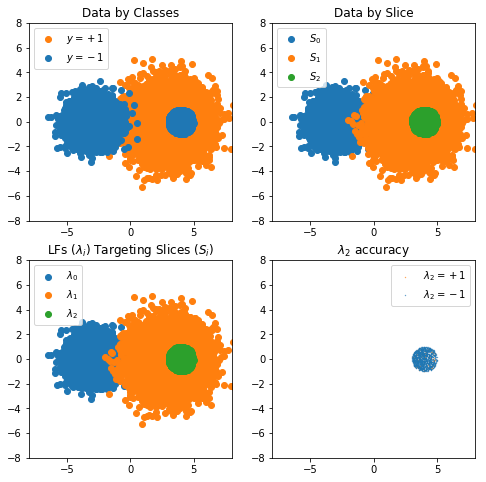

In [6]:
from simulate import data_config as config
from synthetics_utils import generate_synthetic_data
X, Y, C, L = generate_synthetic_data(config)
visualize_data(X, Y, C, L)

In [7]:
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]
C_train, C_test = C[:split_idx], C[split_idx:]
L_train, L_test = L[:split_idx], L[split_idx:]
# visualize_data(X_train, Y_train, C_train, L_train)
# visualize_data(X_test, Y_test, C_test, L_test)

## Simulate

target op: 0.1, found op: 0.10293333333333334, found r: 0.8000000000000002


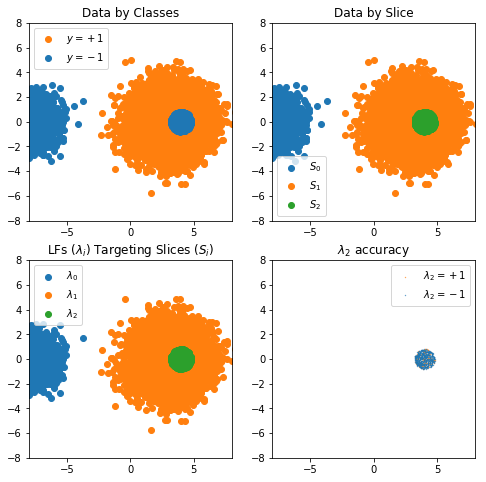

{'N': 10000,
 'mus': [array([-8,  0]), array([3, 0])],
 'labels': [-1, 1],
 'props': [0.25, 0.75],
 'variances': [1, 2],
 'head_config': {'h': 4, 'k': 0, 'r': 1, 'slice_label': -1},
 'accs': [0.75, 0.75, 0.75],
 'covs': [0.9, 0.9, 0.9]}

In [8]:
from simulate import data_config as config
from synthetics_utils import generate_synthetic_data

# Setting 1: Separable case
# config = {
#     # data generation
#     "N": 10000, # num data points
#     "mus": [
#         np.array([-6, 4]), # Mode 1: Y = -1
#         np.array([3, 4]), # Mode 2: Y = 1,
#         np.array([6, -3])
#     ],
#     "labels": [-1, 1, -1], # labels of each slice
#     "props": [0.45, 0.45, 0.1], # proportion of data in each mode
#     "variances": [0.5, 0.5, 0.5], # proportion of data in each mode
#     "head_config": None,

#     "accs": np.array([0.999, 0.999, 0.999]), # default accuracy of LFs
#     "covs": np.array([1., 1., 1.]), # default coverage of LFs
# }

# Setting 2: Donut
config['mus'] = [
    np.array([-8, 0]), # Mode 1: Y = -1
    np.array([3, 0]), # Mode 2: Y = 1,
]
config['accs'] = [0.75, 0.75, 0.75]
config['covs'] = [0.9, 0.9, 0.9]
X, Y, C, L = generate_synthetic_data(config, 'op', 0.1)
visualize_data(X, Y, C, L)
config

In [9]:
from metal.end_model import EndModel

split_idx = int(len(X) * 0.8)

X = torch.Tensor(X)
# X = X.astype(np.float32)
Y_cat = Y.copy().astype(np.int32)
Y_cat[Y==-1] = 2
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y_cat[:split_idx], Y_cat[split_idx:]
L_train, L_test = L[:split_idx], L[split_idx:]
C_train, C_test = C[:split_idx], C[split_idx:]


In [10]:
from simulate import eval_model
def eval_on_slices(model, X_test, Y_test, C_test):
    S0_idx, S1_idx, S2_idx = (
        np.where(C_test == 0)[0],
        np.where(C_test == 1)[0],
        np.where(C_test == 2)[0],
    )
    eval_dict = {"S0": S0_idx, "S1": S1_idx, "S2": S2_idx}

    preds, Y = end_model._get_predictions((X_test, Y_test), return_probs=False)
    
    print ("S0:", np.sum((preds == Y)[S0_idx]) / len(Y[S0_idx]))
    print ("S1:", np.sum((preds == Y)[S1_idx]) / len(Y[S1_idx]))
    print ("S2:", np.sum((preds == Y)[S2_idx]) / len(Y[S2_idx]))

In [12]:
end_model = EndModel([2,10,10,10,10,2], seed=123) # seed = 123
end_model.train_model(
    (X_train, Y_train), 
    dev_data=(X_test, Y_test), 
    lr=0.005,
    n_epochs=20
)

eval_on_slices(end_model, X_test, Y_test, C_test)


Network architecture:
Sequential(
  (0): IdentityModule()
  (1): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (3): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (4): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): ReLU()
  )
  (5): Linear(in_features=10, out_features=2, bias=True)
)




Saving model at iteration 0 with best score 0.910
[E:0]	Train Loss: 0.226	Dev accuracy: 0.910



Saving model at iteration 1 with best score 0.924
[E:1]	Train Loss: 0.129	Dev accuracy: 0.924



Saving model at iteration 2 with best score 0.932
[E:2]	Train Loss: 0.116	Dev accuracy: 0.932



Saving model at iteration 3 with best score 0.940
[E:3]	Train Loss: 0.109	Dev accuracy: 0.940



Saving model at iteration 4 with best score 0.946
[E:4]	Train Loss: 0.106	Dev accuracy: 0.946



Saving model at iteration 5 with best score 0.946
[E:5]	Train Loss: 0.102	Dev accuracy: 0.946



Saving model at iteration 6 with best score 0.947
[E:6]	Train Loss: 0.099	Dev accuracy: 0.947



Saving model at iteration 7 with best score 0.952
[E:7]	Train Loss: 0.097	Dev accuracy: 0.952



Saving model at iteration 8 with best score 0.967
[E:8]	Train Loss: 0.081	Dev accuracy: 0.967



[E:9]	Train Loss: 0.060	Dev accuracy: 0.943



Saving model at iteration 10 with best score 0.980
[E:10]	Train Loss: 0.053	Dev accuracy: 0.980



Saving model at iteration 11 with best score 0.986
[E:11]	Train Loss: 0.052	Dev accuracy: 0.986



Saving model at iteration 12 with best score 0.989
[E:12]	Train Loss: 0.032	Dev accuracy: 0.989



[E:13]	Train Loss: 0.032	Dev accuracy: 0.987



Saving model at iteration 14 with best score 0.992
[E:14]	Train Loss: 0.029	Dev accuracy: 0.992



[E:15]	Train Loss: 0.031	Dev accuracy: 0.978



[E:16]	Train Loss: 0.030	Dev accuracy: 0.985



[E:17]	Train Loss: 0.028	Dev accuracy: 0.990



[E:18]	Train Loss: 0.027	Dev accuracy: 0.988



[E:19]	Train Loss: 0.027	Dev accuracy: 0.989
Restoring best model from iteration 14 with score 0.992
Finished Training
Accuracy: 0.992
        y=1    y=2   
 l=1   1305    11    
 l=2     6     678   
S0: 1.0
S1: 0.9954233409610984
S2: 0.9430051813471503


In [13]:
from metal.contrib.slicing.online_dp import MLPModule, SliceDPModel

input_module_class = MLPModule
init_kwargs = {
   'input_dim': 2,
    'middle_dims': [10, 10],
   'bias': True
 }
accs = [0.999, 0.999, 0.999]
# accs = [1.0, 1.0, 1.0]

# weights for manual reweighting case
weights = np.ones(3, dtype=np.float32)
weights[-1] = 2.0

r = 10
init_kwargs.update({"output_dim": r})
slice_model = SliceDPModel(
    input_module_class(**init_kwargs),
    accs,
    r=r,
    reweight=True,
    slice_weight=0.5,
    L_weight=weights,
)

slice_model.train_model(
    (X_train, L_train), 
    dev_data=(X_test, Y_test), 
    lr=0.005,
    n_epochs=20
)

eval_on_slices(slice_model, X_test, Y_test, C_test)

Slice Heads:
Reweighting: True
Slice Weight: 0.5
Input Network: Sequential(
  (0): MLPModule(
    (input_layer): Sequential(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): ReLU()
      (2): Linear(in_features=10, out_features=10, bias=True)
      (3): ReLU()
      (4): Linear(in_features=10, out_features=10, bias=True)
      (5): ReLU()
    )
  )
)
L_head: Linear(in_features=10, out_features=3, bias=False)
Y_head: Linear(in_features=20, out_features=2, bias=False)



Saving model at iteration 0 with best score 0.903
[E:0]	Train Loss: 0.020	Dev accuracy: 0.903



[E:1]	Train Loss: 0.020	Dev accuracy: 0.903



[E:2]	Train Loss: 0.020	Dev accuracy: 0.903



[E:3]	Train Loss: 0.020	Dev accuracy: 0.903



[E:4]	Train Loss: 0.020	Dev accuracy: 0.903



[E:5]	Train Loss: 0.020	Dev accuracy: 0.903



[E:6]	Train Loss: 0.020	Dev accuracy: 0.903



Saving model at iteration 7 with best score 0.906
[E:7]	Train Loss: 0.020	Dev accuracy: 0.906



Saving model at iteration 8 with best score 0.908
[E:8]	Train Loss: 0.020	Dev accuracy: 0.908



Saving model at iteration 9 with best score 0.964
[E:9]	Train Loss: 0.020	Dev accuracy: 0.964



[E:10]	Train Loss: 0.020	Dev accuracy: 0.957



Saving model at iteration 11 with best score 0.969
[E:11]	Train Loss: 0.020	Dev accuracy: 0.969



[E:12]	Train Loss: 0.020	Dev accuracy: 0.953



[E:13]	Train Loss: 0.020	Dev accuracy: 0.969



[E:14]	Train Loss: 0.020	Dev accuracy: 0.953



Saving model at iteration 15 with best score 0.977
[E:15]	Train Loss: 0.020	Dev accuracy: 0.977



[E:16]	Train Loss: 0.020	Dev accuracy: 0.964



[E:17]	Train Loss: 0.020	Dev accuracy: 0.971



[E:18]	Train Loss: 0.020	Dev accuracy: 0.975



[E:19]	Train Loss: 0.020	Dev accuracy: 0.975
Restoring best model from iteration 15 with score 0.977
Finished Training
Accuracy: 0.977
        y=1    y=2   
 l=1   1284    19    
 l=2    27     670   
S0: 1.0
S1: 0.9954233409610984
S2: 0.9430051813471503


In [ ]:
# %%time

# # # Flip the signs
# # config['labels'] = [1, -1]
# # config['head_config']['slice_label'] = 1

# experiment = "[10x6]_bs256"
# X_VAR = "op"
# X_VAL = 0.1

# from simulate import simulate
# experiment_config = {
#     "num_trials": 1,
#     "x_range": [X_VAL],    
#     "x_var": X_VAR,
#     "input_module_kwargs": {
#        'input_dim': 2,
#         'middle_dims': [10, 10],
#        'bias': True
#      },
#     "train_kwargs": {
#         "n_epochs":20,
#         "print_every":10,
#         "validation_metric":"accuracy",
#         "disable_prog_bar":True,
#         "verbose":True,
#         "lr": 0.005,
#         "checkpoint_runway": 5,
#     },
#     "train_prop": 0.8,
#     "tensorboard_logdir": f"./run_logs/{experiment}"
# }


# baseline_scores, manual_scores, attention_scores = \
#     simulate(config, generate_synthetic_data, experiment_config)

In [ ]:
# def get_slice_scores(scores, key=0.9):
#     S0 = np.mean([s['S0'] for s in scores[key]])
#     S1 = np.mean([s['S1'] for s in scores[key]])
#     S2 = np.mean([s['S2'] for s in scores[key]])
#     overall = np.mean([s['overall'] for s in scores[key]])    
#     return {'S0':S0, 'S1':S1, 'S2':S2, 'overall':overall}

In [ ]:
# for k in baseline_scores.keys():
#     print (k)
#     print ('base:', get_slice_scores(baseline_scores, k))
#     print ('manual:', get_slice_scores(manual_scores, k))
#     print ('attention:', get_slice_scores(attention_scores, k))

In [ ]:
# results = {
#     'baseline': dict(baseline_scores),
#     'manual': dict(manual_scores),
#     'attention': dict(attention_scores)
# }

# from synthetics_utils import plot_slice_scores
# plot_slice_scores(results, 'S2', xlabel='Head Acc.')
# plt.show()
# plot_slice_scores(results, 'S1', xlabel='Head Acc.')
# plt.show()
# plot_slice_scores(results, 'S0', xlabel='Head Acc.')
# plt.show()
# plot_slice_scores(results, 'overall', xlabel='Head Acc.')